In [3]:
import Model
import utils
import pickle
import numpy as np
import keras
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,precision_recall_fscore_support
from settings import in_size, out_size, train_start, train_end, valid_start, valid_end,  interval, test_start, test_end
from utils.Model import inference
#%matplotlib notebook
%config InlineBackend.figure_formats = {'png', 'retina'}

In [4]:
_ = pickle.load(open("./data/data.pickle","rb"))
cluster_sizes = _["cluster_sizes"]
cluster2id = _["cluster2id"]
locations = _["locations"]
timestamps = _["timestamps"]
raw_data = _["raw_data"]
cluster_data = _["cluster_data"]
onehot_data = _["onehot_data"]
id2cluster = [None for i in range(len(locations))]
for cluster,ids in cluster2id.items():
    for pid in ids:
        id2cluster[pid] = cluster

In [5]:
Model.set_gpu("7")

'7'

In [6]:
tests = utils.data_iterator(cluster_data[test_start:test_end],timestamps[test_start:test_end],in_size,out_size=out_size,slide=1)
tests_onehot = utils.data_iterator(onehot_data[test_start:test_end],timestamps[test_start:test_end],in_size,out_size=out_size,slide=1)
test_data_time = timestamps[test_start:test_end]

In [7]:
custom_objects = {'mse_inc':Model.mse_inc,'mse_inc_total':Model.mse_inc_total,'mae_inc':Model.mae_inc,'mae_inc_total':Model.mae_inc_total}

In [8]:
def evaluate(modelpath,tests,clustered=True,modelname=""):
    
    clf = keras.models.load_model(modelpath,custom_objects=custom_objects)
    preds = clf.predict(tests[0])
    
    if not clustered:
        preds_t = preds > 0.5
        for j in range(out_size):
            print(interval * (j+1),"分後 accuracy \t:",accuracy_score(tests[1][:,j,].reshape(-1),preds_t[:,j,].reshape(-1)))
        _ = [np.sum(preds[:,:,cluster2id[pid]],axis=2)[:,:,np.newaxis] for pid in range(len(cluster2id))]
        pr = np.round(np.concatenate(_,axis=2))
        _ = [np.sum(tests[1][:,:,cluster2id[pid]],axis=2)[:,:,np.newaxis] for pid in range(len(cluster2id))]
        ts = np.concatenate(_,axis=2)
        
    else:
        ts = tests[1] * cluster_sizes
        pr = np.round(preds * cluster_sizes)
        
    results = {"mean":[],"max":[],"min":[]}
    for i in range(len(cluster_sizes)):
        inner_results = []
        inner_max = []
        inner_min = []
        print("------cluster id",i,"最大駐車台数",cluster_sizes[i],"台------")
        print("平均絶対値誤差 (正解 - 予測) [台]")
        for j in range(out_size):
            print(interval * (j+1),"分後 \t:",np.round(np.mean(np.abs(ts[:,j,i] - pr[:,j,i])),3))
            inner_results.append(np.round(np.mean(np.abs(ts[:,j,i] - pr[:,j,i])),3))
            inner_max.append(np.round(np.max(np.abs(ts[:,j,i] - pr[:,j,i])),3))
            inner_min.append(np.round(np.min(np.abs(ts[:,j,i] - pr[:,j,i])),3))
        results["mean"].append(inner_results.copy())
        results["max"].append(inner_max.copy())
        results["min"].append(inner_min.copy())
        print("")
        
    print("--------total       最大駐車台数",sum(cluster_sizes),"台--------")
    print("平均絶対値誤差 (正解 - 予測) [台]")
    inner_results = []
    inner_max = []
    inner_min = []
    
    for j in range(out_size):
        print(interval * (j+1),"分後 \t:",np.round(np.mean(np.abs(np.sum(ts[:,j,],axis=1) - np.sum(pr[:,j,],axis=1))),3))
        inner_results.append(np.round(np.mean(np.abs(np.sum(ts[:,j,],axis=1) - np.sum(pr[:,j,],axis=1))),3))
        inner_max.append(np.round(np.max(np.abs(np.sum(ts[:,j,],axis=1) - np.sum(pr[:,j,],axis=1))),3))
        inner_min.append(np.round(np.min(np.abs(np.sum(ts[:,j,],axis=1) - np.sum(pr[:,j,],axis=1))),3))
    results["mean"].append(inner_results.copy())
    results["max"].append(inner_max.copy())
    results["min"].append(inner_min.copy())
    ts = np.sum(ts[::out_size],axis=2)
    pr = np.sum(pr[::out_size],axis=2)
    plt.rcParams["font.family"] =  'Times New Roman'
    plt.rcParams["font.size"] =  14

    plt.figure(figsize=(16,4))
    
    plt.ylabel("Number of available parking lots")
    plt.xlabel("Date")
    colorlist =  ["r", "g", "b", "c", "m", "y","orange","pink","purple"]
    for term, tmp in enumerate(zip(ts,pr)):
        #x = range(term*out_size,term*out_size+out_size)
        gx = test_data_time[term*out_size:term*out_size+out_size]
        ts_i,pr_i = tmp
        color = colorlist[term%len(colorlist)]
        plt.plot(gx,323-np.round(ts_i),":",color=color)
        plt.plot(gx,323-np.round(pr_i),"-",color=color)
    plt.plot([],[],":",label="Measured value",color="black") #凡例用
    plt.plot([],[],"-",label="Predicted value",color="black")
    plt.legend()
    plt.savefig("./results/pdf/"+modelname+".pdf")
    plt.show()
    return results

In [26]:
def save_csv(results,namehead='result'):
    pd.DataFrame(results['mean'],
                 columns=[str((i+1) * interval)+" min" for i in range(out_size)],
                 index = [str(idx)+" ("+str(cluster_sizes[idx])+"台)" for idx in range(len(cluster_sizes))] + ["total"]
                ).to_csv("./results/csv/"+namehead+".csv",encoding="utf8")
#     pd.DataFrame(results['max'],
#                  columns=[str((i+1) * interval)+" min" for i in range(out_size)],
#                  index = [str(idx)+" ("+str(cluster_sizes[idx])+"台)" for idx in range(len(cluster_sizes))] + ["total"]
#                 ).to_csv("./results/csv/"+namehead+"_max.csv",encoding="utf8")
#     pd.DataFrame(results['min'],
#                  columns=[str((i+1) * interval)+" min" for i in range(out_size)],
#                  index = [str(idx)+" ("+str(cluster_sizes[idx])+"台)" for idx in range(len(cluster_sizes))] + ["total"]
#                 ).to_csv("./results/csv/"+namehead+"_min.csv",encoding="utf8")
    return

------cluster id 0 最大駐車台数 10 台------
平均絶対値誤差 (正解 - 予測) [台]
15 分後 	: 0.749
30 分後 	: 0.734
45 分後 	: 0.748
60 分後 	: 0.769
75 分後 	: 0.768
90 分後 	: 0.77
105 分後 	: 0.767
120 分後 	: 0.769

------cluster id 1 最大駐車台数 15 台------
平均絶対値誤差 (正解 - 予測) [台]
15 分後 	: 0.803
30 分後 	: 0.816
45 分後 	: 0.814
60 分後 	: 0.822
75 分後 	: 0.833
90 分後 	: 0.839
105 分後 	: 0.838
120 分後 	: 0.843

------cluster id 2 最大駐車台数 5 台------
平均絶対値誤差 (正解 - 予測) [台]
15 分後 	: 0.404
30 分後 	: 0.392
45 分後 	: 0.406
60 分後 	: 0.416
75 分後 	: 0.422
90 分後 	: 0.427
105 分後 	: 0.424
120 分後 	: 0.429

------cluster id 3 最大駐車台数 13 台------
平均絶対値誤差 (正解 - 予測) [台]
15 分後 	: 0.911
30 分後 	: 0.899
45 分後 	: 0.906
60 分後 	: 0.911
75 分後 	: 0.908
90 分後 	: 0.906
105 分後 	: 0.905
120 分後 	: 0.904

------cluster id 4 最大駐車台数 6 台------
平均絶対値誤差 (正解 - 予測) [台]
15 分後 	: 0.265
30 分後 	: 0.291
45 分後 	: 0.3
60 分後 	: 0.302
75 分後 	: 0.304
90 分後 	: 0.301
105 分後 	: 0.298
120 分後 	: 0.301

------cluster id 5 最大駐車台数 6 台------
平均絶対値誤差 (正解 - 予測) [台]
15 分後 	: 1.015
30 分後 	: 0.978
45 分後 	

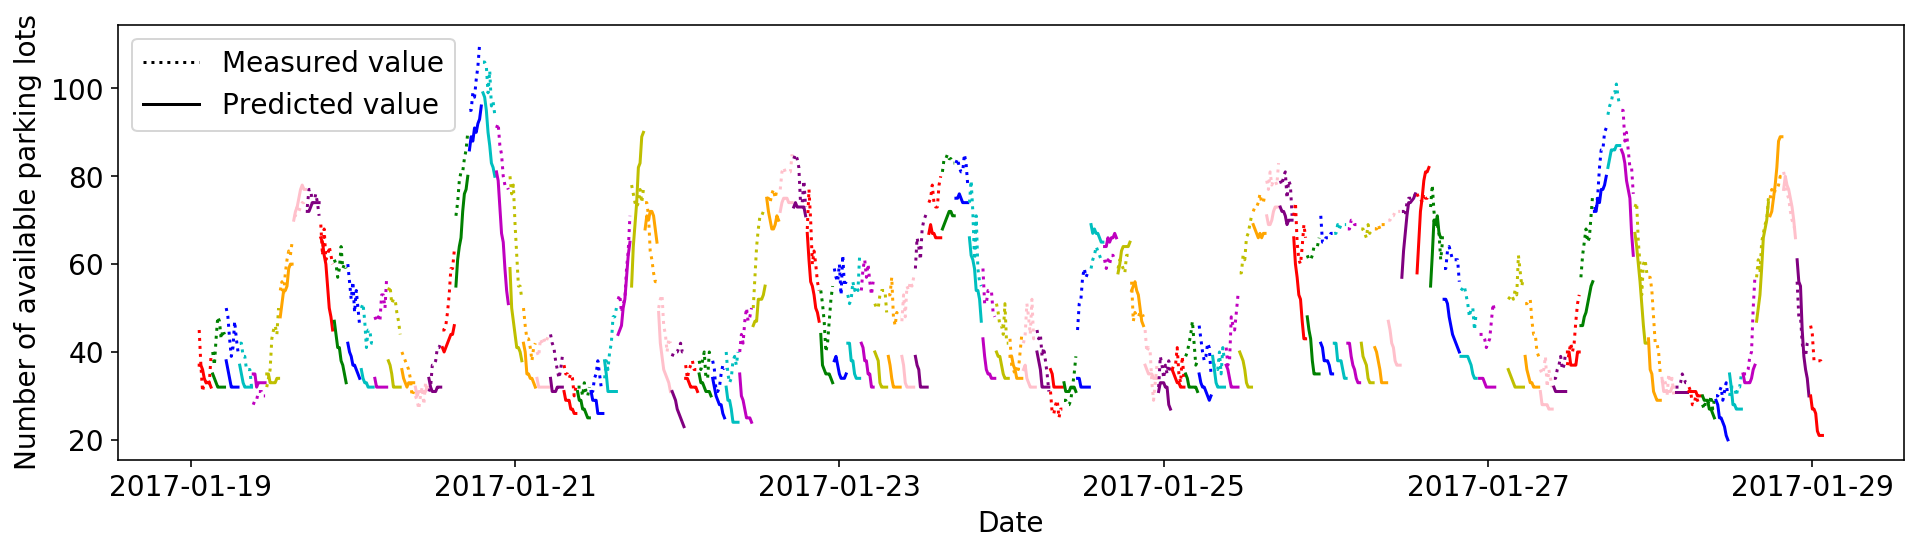

In [37]:
save_csv(evaluate("models/s2s_mae_half.clf",tests,True,modelname="LSTM_0.5"),"LSTM_0.5")
save_csv(evaluate("models/s2s_mae_one.clf",tests,True,modelname="LSTM_1.0"),"LSTM_1.0")
save_csv(evaluate("models/s2s_mae_one_half.clf",tests,True,modelname="LSTM_1.5"),"LSTM_1.5")
save_csv(evaluate("models/s2s_mae_two.clf",tests,True,modelname="LSTM_2.0"),"LSTM_2.0")
save_csv(evaluate("models/s2s_mae.clf",tests,True,modelname="LSTM_full"),"LSTM_full")

------cluster id 0 最大駐車台数 10 台------
平均絶対値誤差 (正解 - 予測) [台]
15 分後 	: 0.925
30 分後 	: 0.959
45 分後 	: 0.941
60 分後 	: 0.926
75 分後 	: 0.898
90 分後 	: 0.888
105 分後 	: 0.871
120 分後 	: 0.867

------cluster id 1 最大駐車台数 15 台------
平均絶対値誤差 (正解 - 予測) [台]
15 分後 	: 0.751
30 分後 	: 0.742
45 分後 	: 0.798
60 分後 	: 0.829
75 分後 	: 0.836
90 分後 	: 0.842
105 分後 	: 0.845
120 分後 	: 0.853

------cluster id 2 最大駐車台数 5 台------
平均絶対値誤差 (正解 - 予測) [台]
15 分後 	: 0.466
30 分後 	: 0.45
45 分後 	: 0.446
60 分後 	: 0.444
75 分後 	: 0.444
90 分後 	: 0.446
105 分後 	: 0.442
120 分後 	: 0.441

------cluster id 3 最大駐車台数 13 台------
平均絶対値誤差 (正解 - 予測) [台]
15 分後 	: 0.857
30 分後 	: 0.929
45 分後 	: 0.942
60 分後 	: 0.939
75 分後 	: 0.934
90 分後 	: 0.927
105 分後 	: 0.913
120 分後 	: 0.906

------cluster id 4 最大駐車台数 6 台------
平均絶対値誤差 (正解 - 予測) [台]
15 分後 	: 0.248
30 分後 	: 0.248
45 分後 	: 0.248
60 分後 	: 0.248
75 分後 	: 0.248
90 分後 	: 0.248
105 分後 	: 0.247
120 分後 	: 0.246

------cluster id 5 最大駐車台数 6 台------
平均絶対値誤差 (正解 - 予測) [台]
15 分後 	: 0.819
30 分後 	: 0.968
45 分後

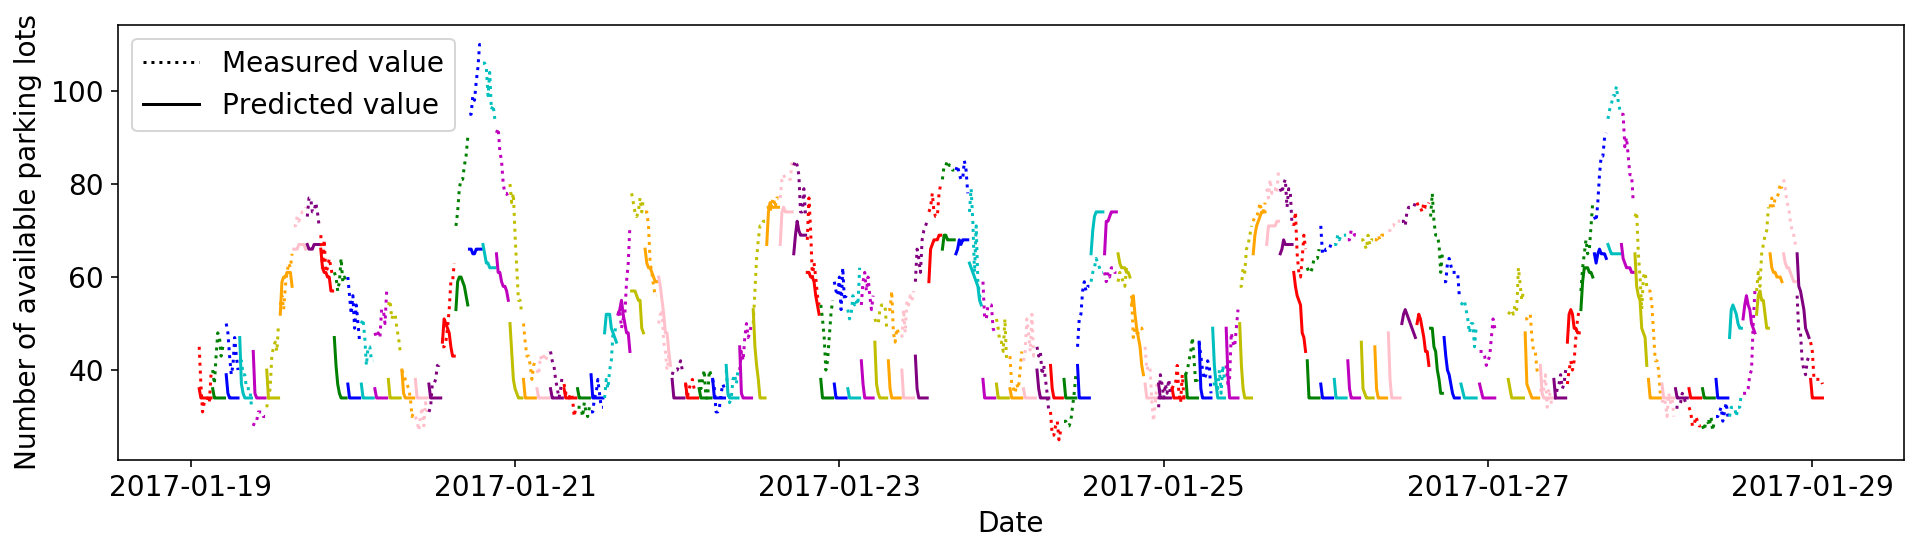

In [40]:
save_csv(evaluate("models/s2s_conv_mae_half.clf",tests,True,modelname="CNN_0.5"),"CNN_0.5")
save_csv(evaluate("models/s2s_conv_mae_one.clf",tests,True,modelname="CNN_1.0"),"CNN_1.0")
save_csv(evaluate("models/s2s_conv_mae_one_half.clf",tests,True,modelname="CNN_1.5"),"CNN_1.5")
save_csv(evaluate("models/s2s_conv_mae_two.clf",tests,True,modelname="CNN_2.0"),"CNN_2.0")
save_csv(evaluate("models/s2s_conv_mae.clf",tests,True,modelname="CNN_full"),"CNN_full")

In [ ]:
inference.save_gnn_csv('models/s2s_gnn_mae_encoder_half.pt', 'models/s2s_gnn_mae_decoder_half.pt', 'GNN_0.5')
inference.save_gnn_csv('models/s2s_gnn_mae_encoder_one.pt', 'models/s2s_gnn_mae_decoder_one.pt', 'GNN_1.0')
inference.save_gnn_csv('models/s2s_gnn_mae_encoder_one_half.pt', 'models/s2s_gnn_mae_decoder_one_half.pt', 'GNN_1.5')
inference.save_gnn_csv('models/s2s_gnn_mae_encoder_two.pt', 'models/s2s_gnn_mae_decoder_two.pt', 'GNN_2.0')
inference.save_gnn_csv('models/s2s_gnn_mae_encoder_full.pt', 'models/s2s_gnn_mae_decoder_two.pt', 'GNN_full')